In [2]:
import rebound as rb
import celmech as cm
import numpy as np
from celmech.secular import SecularSystemSimulation

In [3]:
import matplotlib.pyplot as plt

# Full solar system

In [4]:
arc_sec_per_yr = 60*60*180 / np.pi
try:
    sim = rb.Simulation("full.sim")
except:
    sim = rb.Simulation()
    sim.units = ("Msun","AU","yr")
    sim.add("Sun")
    sim.add("Mercury")
    sim.add("Venus")
    sim.add("Earth")
    sim.add("Mars")
    sim.add("Jupiter")
    sim.add("Saturn")
    sim.add("Uranus")
    sim.add("Neptune")
    sim.move_to_com()
    sim.save("full.sim")

In [5]:
pvars = cm.Poincare.from_Simulation(sim)
pham = cm.PoincareHamiltonian(pvars)
# terrestrial planets to 4th order
for i in range(1,5):
    for j in range(i+1,5):
        pham.add_secular_terms(min_order=2,max_order=4,indexIn=i,indexOut=j)
# terrestrial/giant coupling @ 4th order
for i in range(1,5):
    for j in range(5,9):
        pham.add_secular_terms(2,4,indexIn=i,indexOut=j)

In [6]:
import sympy as sp

In [8]:
results=np.load("integration_result.npz")

In [12]:
y=results['trajectory']

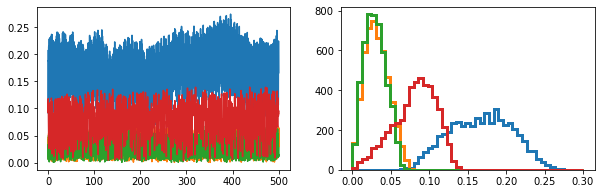

In [25]:
fig,ax=plt.subplots(1,2,figsize=(10,3))
for i in range(4):
    L10=pham.Lambda0s[i+1].xreplace(pham.H_params)
    e=np.sqrt((y[:,2*i]**2 + y[:,2*i+11]**2)/L10)
    l,=ax[0].plot(results['time']/1e6,e)
    ax[1].hist(e,bins=np.linspace(0,0.3,50),histtype='step',color=l.get_color(),lw=3)

# parse synthetic secular theory data

In [6]:
gvec = np.load("../synthetic_secular_soln/gvec.npy")
svec = np.load("../synthetic_secular_soln/svec.npy")
phase_e = np.load("../synthetic_secular_soln/phase_vec_e.npy")
phase_I = np.load("../synthetic_secular_soln/phase_vec_I.npy")
Smatrix_e = np.load("../synthetic_secular_soln/Secc_mtrx.npy")
Smatrix_I = np.load("../synthetic_secular_soln/Sinc_mtrx.npy")

$ \eta_i  = \sqrt{2\Gamma_i}\sin\varpi_i \approx \sqrt{\Lambda_i}e_i\sin\varpi_i = \sqrt{\Lambda_i}\Im[{z_i}]$

In [7]:
#eta_kappa_pairs = [pham.qp_pairs[3 * i + 1] for i in range(4,8)]
rule = dict()
phi = sp.symbols("phi(5:9)",real=True)
psi = sp.symbols("psi(5:9)",real=True)
delta = sp.symbols("delta")
for i in range(4,8):
    eta_i,kappa_i = pham.qp_pairs[3 * i + 1]
    rho_i,sigma_i = pham.qp_pairs[3 * i + 2]
    L0 = pham.Lambda0s[i+1].xreplace(pham.H_params)
    rule[eta_i]   = -1 * delta * np.sqrt(L0) * (Smatrix_e[i,4] * sp.sin(phi[0]) + Smatrix_e[i,5] * sp.sin(phi[1]))
    rule[kappa_i] =      delta * np.sqrt(L0) * (Smatrix_e[i,4] * sp.cos(phi[0]) + Smatrix_e[i,5] * sp.cos(phi[1]))
    
    rule[rho_i]   = -2 * delta * np.sqrt(L0) * (Smatrix_I[i,4] * sp.sin(phase_I[4]) + Smatrix_I[i,5] * sp.sin(psi[1]))
    rule[sigma_i] =  2 * delta * np.sqrt(L0) * (Smatrix_I[i,4] * sp.cos(phase_I[4]) + Smatrix_I[i,5] * sp.cos(psi[1]))

In [8]:
newham = pham.H.xreplace(rule)


In [9]:
Lambdas=set([pham.qp_pairs[3*i][1] for i in range(8)])
newham = newham.func(*[a for a in newham.args if len(Lambdas.intersection(a.free_symbols)) == 0 ])

In [10]:
newham = (newham.xreplace({delta:0}) + newham.diff(delta).xreplace({delta:0}))

In [11]:
newham = newham.xreplace(pham.H_params)

In [12]:
newham = newham.expand()

In [13]:
planet_vars = [q for q,p in pham.qp_pairs if q in newham.free_symbols] + [p for q,p in pham.qp_pairs if q in newham.free_symbols]
myvars  = [q for q,p in pham.qp_pairs if q in newham.free_symbols]
myvars += list(sp.symbols("phi(5:7)",real=True)) + list(sp.symbols("psi(6:7)",real=True))
myvars +=[p for q,p in pham.qp_pairs if p in newham.free_symbols] 
myvars += list(sp.symbols("Phi(5:7)",real=True)) + list(sp.symbols("Psi(6:7)",real=True))

In [14]:
htot  = newham + myvars[-3] * gvec[4] + myvars[-2] * gvec[5] + myvars[-1] * svec[5]

In [29]:
inits = {s:pham.qp[s] for s in planet_vars}
inits[phi[0]] = phase_e[4]
inits[phi[1]] = phase_e[5]
inits[psi[1]] = phase_I[5]
Phi = sp.symbols("Phi(5:7)",real=True)
Psi = sp.symbols("Psi(6:7)",real=True)
inits[Phi[0]] = 0
inits[Phi[1]] = 0
inits[Psi[0]] = 0
values = np.array([inits[s] for s in myvars])

In [30]:
state = cm.PhaseSpaceState(myvars,values)
sham = cm.Hamiltonian(htot,{},state)

In [33]:
import pickle
with open("secular_hamiltonian_4th_order.pkl","wb") as fi:
    pickle.dump((htot,state),fi)

In [18]:
sham.calculate_energy()

-8.530188965254536e-14

In [19]:
%%time
times = np.linspace(sham.t,sham.t+3e6,64)
results = np.zeros((len(times),sham.N_dim))
for i,t in enumerate(times):
    sham.integrate(t)
    results[i] = sham.values

CPU times: user 4.6 s, sys: 4.72 ms, total: 4.6 s
Wall time: 4.66 s


In [134]:
import pickle

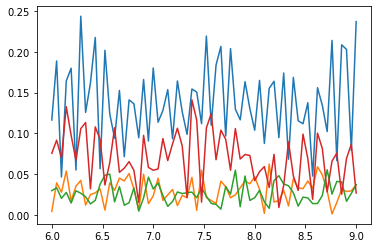

In [128]:
for i in range(1,5):
    L10=pham.H_params[pham.Lambda0s[i]]
    plt.plot(times/1e6,np.sqrt((results[:,2*i-2]**2 + results[:,12 + 2*i-2]**2)/L10))


In [130]:
sim.integrator = 'whfast'
cm.nbody_simulation_utilities.set_time_step(sim,1/20.)

In [132]:
%%time
sim.integrate(3e6)

CPU times: user 13min 28s, sys: 6.4 s, total: 13min 35s
Wall time: 14min 3s


In [20]:
from celmech.rk_integrator import RKIntegrator

In [21]:
def flow(y):
    return sham.flow_func(*y).reshape(-1)
def flow_and_jac(y):
    return flow(y), sham.jacobian_func(*y)

In [23]:
from celmech.miscellaneous import _machine_eps
Psec = np.min((2 *np.pi / gvec))
h = Psec / 20
integrator = RKIntegrator(
    flow,
    flow_and_jac,
    sham.N_dim,
    h,
    rtol=_machine_eps,
    atol=1e-12,
    rk_method='GL6',
    rk_root_method='Newton',
    max_iter=10
)

In [24]:
import time

In [38]:
ics=np.array(sham.values)

In [39]:
np.save("./inits" , ics)

In [25]:
dts = h * np.logspace(0,1,8)
steps = np.array(3e6//dts,dtype=int)
dEs = []
times = []
for dt,N in zip(dts,steps):
    integrator.dt = dt
    y = np.array(sham.values)
    E = np.zeros(N)
    st = time.time()
    for i in range(N):
        E[i] = sham.H_func(*y)
        y = integrator.rk_step(y)
    et = time.time()
    dEs.append(np.sqrt(np.var((E-np.mean(E))/np.mean(E))))
    times.append(et-st)

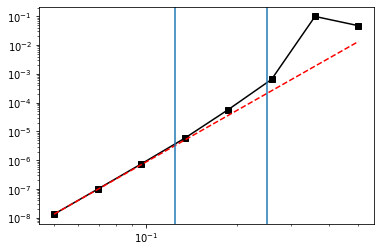

In [26]:
plt.plot(dts/Psec,dEs,'ks-')
plt.plot(dts/Psec,(dEs[0]) * (dts/dts[0])**6 ,'r--')
plt.xscale('log')
plt.yscale('log')
plt.axvline(1/4)
plt.axvline(1/8)

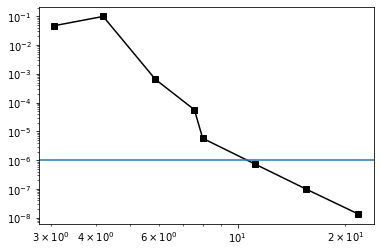

In [28]:
plt.plot(times,dEs,'ks-')
#plt.plot(dtim,(dEs[0]) * (dts/dts[0])**6 ,'r--')
plt.xscale('log')
plt.yscale('log')
plt.axhline(1e-6)

In [114]:
N = 1000

ytraj = np.zeros((N,y.shape[0]))
for i in range(N):
    ytraj[i] = y
    y = integrator.rk_step(y)

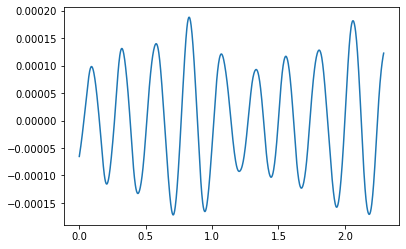

In [115]:
plt.plot(np.arange(N) * h/(1e6),ytraj[:,0])

In [141]:
N= len(times)
Nfreq = 4
for i in range(1,5):
    z=(results[:,12 + 2*i-2]-1j*results[:,2*i-2])/np.sqrt(L10)
    res1=fmft(times[:N//2],z[:N//2],Nfreq)
    res2=fmft(times[N//2:],z[N//2:],Nfreq)
    freqs1 = np.array(list(res1.keys()))
    freqs2 =  np.array(list(res2.keys()))
    print(np.log10(0.5 * np.abs((freqs2 - freqs1) / (freqs2 + freqs1))))

[-2.79235991 -5.84881799 -4.08695507 -2.28611239]
[-4.10242254 -5.9269948  -1.8756583  -1.76057779]
[-4.1021111  -6.23960361 -1.87586246 -1.76058906]
[-2.84988763 -1.89070206 -1.78449157 -6.19730675]


# Numerical secular solution for giant planets

In [ ]:
rm outer_solar_system_10Myr.sa

In [ ]:
save_file = "outer_solar_system_10Myr.sa"
bodies = ["Sun","Jupiter","Saturn","Uranus","Neptune"]


from celmech.nbody_simulation_utilities import get_simarchive_integration_results
try:
    results = get_simarchive_integration_results(save_file)
except:
    sim = rb.Simulation()
    sim.units = ("Msun","AU","yr")
    for body in bodies:
        sim.add(body)
    sim.move_to_com()
    sim.integrator = 'whfast'
    sim.ri_whfast.safe_mode=0
    cm.nbody_simulation_utilities.set_time_step(sim,1/30)

    Tfin = 4*1e7
    Nout = 4*512

    sim.automateSimulationArchive(save_file,interval=Tfin/Nout,deletefile=True)

    sim.integrate(Tfin)
    results = get_simarchive_integration_results(save_file)

In [ ]:
# from M&D pg. 303
gtrue = np.array([4.29591,27.77406])

In [ ]:
from celmech.miscellaneous import frequency_modified_fourier_transform

# Calculate complex eccentricities
results['z'] = results['e'] * np.exp(1j * results['pomega'])

# Number of Fourier harmonics to calculate for each planet
Nfreq=6

time = results['time']
arc_sec_per_yr = 60*60*180 / np.pi

ampdict = dict()
title="Frequency [\"/yr] | Amplitude"
print(title)
print("="*len(title))
for i,planet in enumerate(bodies[1:]):
    print(planet)
    print("-"*len(planet))


    # Calculate results
    z = results['z'][i]
    freq_results = frequency_modified_fourier_transform(time,z,Nfreq)
    
    
    # results are stored as a dictionary with entries
    # in the form: {nu_j:a_j}
    
    for freq,amp in freq_results.items():
        freq_scaled = freq * arc_sec_per_yr
        mode_i = 5 + np.argmin(np.abs(gtrue - freq_scaled))
        abs_amp = np.abs(amp)
        if np.abs(gtrue[mode_i-5]-freq_scaled) < 0.1 * freq_scaled:
            print(mode_i,freq_scaled)
            ampdict[sp.symbols("a{0}{1}".format(5+i,mode_i))] = abs_amp
        print("{:+.2f}\t\t|\t{:.4f}".format(freq_scaled, abs_amp))
print("\n")

In [ ]:
strue = np.array([0.0,-26.])


# Calculate complex eccentricities
results['zeta'] = np.sin(0.5 * results['inc']) * np.exp(1j * results['Omega'])

# Number of Fourier harmonics to calculate for each planet
Nfreq=4

time = results['time']
arc_sec_per_yr = 60*60*180 / np.pi


title="Frequency [\"/yr] | Amplitude"
print(title)
print("="*len(title))
for i,planet in enumerate(bodies[1:]):
    print(planet)
    print("-"*len(planet))


    # Calculate results
    z = results['zeta'][i]
    freq_results = frequency_modified_fourier_transform(time,z,Nfreq)
    
    
    # results are stored as a dictionary with entries
    # in the form: {nu_j:a_j}
    
    for freq,amp in freq_results.items():
        freq_scaled = freq * arc_sec_per_yr
        mode_i = 5 + np.argmin(np.abs(strue - freq_scaled))
        abs_amp = np.abs(amp)
        if np.abs(strue[mode_i-5]-freq_scaled) < .5:
            print(mode_i,freq_scaled)
            ampdict[sp.symbols("b{0}{1}".format(5+i,mode_i))] = abs_amp
        print("{:+.2f}\t\t|\t{:.4f}".format(freq_scaled, abs_amp))
print("\n")

In [ ]:
ampdict

In [ ]:
2757/1e5 * 0.5

In [ ]:
a

In [ ]:
{key:val.subs(amp_values_dict) for key,val in rule.items()}

In [ ]:
rule

In [ ]:
ampdict

# extras

In [100]:
from celmech.disturbing_function import list_secular_terms

In [101]:
def outer_planet_element_power(k,nu):
    _,_,_,k4,_,k6 = k
    _,nu2,_,nu4 = nu
    return np.abs(k4) + np.abs(k6) + 2 * nu2 + 2 * nu4

In [102]:
gp_terms=[t for t in list_secular_terms(2,4) if outer_planet_element_power(*t)<2]

In [103]:
len(gp_terms),len(list_secular_terms(2,4))

(14, 37)